# Simple CNN on dataset

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import multi_gpu_model


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = '../dataset/train'
validation_data_dir = '../dataset/test'
nb_train_samples = 194
nb_validation_samples = 49
epochs = 50
batch_size = 4

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [3]:
from keras.applications.inception_v3 import InceptionV3
import numpy as np
base_model = InceptionV3(weights='imagenet', input_shape=(img_width, img_height, 3), pooling = 'avg', include_top = False)

#adam = keras.optimizers.Adam(lr=1e-4)
#model.compile(loss='binary_crossentropy',
#              optimizer=adam,
#              metrics=['accuracy'])

x = base_model.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


adam = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()









87916544/87910968 [==============================] - 101s 1us/step

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=(0.1, 0.9))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255, samplewise_center=True,
    samplewise_std_normalization=True,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 193 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [5]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

cb_list = [early_stop, reduce_lr]

In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = cb_list)

Epoch 1/50
48/48 [==============================] - 66s 1s/step - loss: 0.8096 - acc: 0.5988 - val_loss: 0.9262 - val_acc: 0.6042
Epoch 2/50
48/48 [==============================] - 50s 1s/step - loss: 0.5865 - acc: 0.7082 - val_loss: 1.2288 - val_acc: 0.6000
Epoch 3/50
48/48 [==============================] - 55s 1s/step - loss: 0.5164 - acc: 0.7294 - val_loss: 0.9268 - val_acc: 0.7333

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/50
48/48 [==============================] - 55s 1s/step - loss: 0.4980 - acc: 0.7916 - val_loss: 1.0029 - val_acc: 0.7333
Epoch 5/50
48/48 [==============================] - 54s 1s/step - loss: 0.5730 - acc: 0.7398 - val_loss: 0.7330 - val_acc: 0.7111
Epoch 6/50
48/48 [==============================] - 54s 1s/step - loss: 0.4173 - acc: 0.7711 - val_loss: 1.2340 - val_acc: 0.4444
Epoch 7/50
48/48 [==============================] - 53s 1s/step - loss: 0.5117 - acc: 0.7447 - val_loss: 0.6435 - val_acc: 0.6667
Epoch 8/5

In [7]:
history.history.keys()

dict_keys(['acc', 'val_acc', 'loss', 'lr', 'val_loss'])

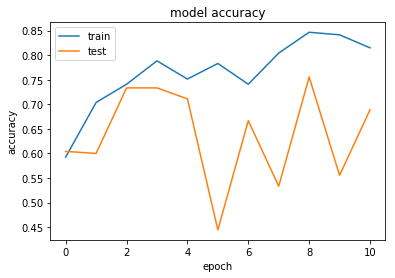

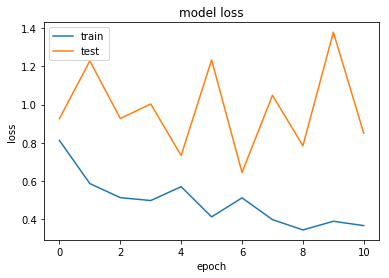

In [8]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        samplewise_center=True,
        samplewise_std_normalization=True,
        brightness_range=(0.1, 0.9))

img = load_img('../datasets/train/N/1_30_1_231.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/train/N/1_30_1_231.jpg'

In [43]:
x_train = []
for i in range(25):
    x_batch, y_batch = next(train_generator)
    x_train.append(x_batch)
    
x_test = []
for i in range(2):
    x_batch, y_batch = next(validation_generator)
    x_test.append(x_batch)
    

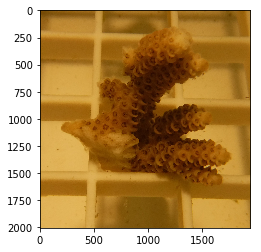

In [60]:
img = load_img('../dataset/test/N/1_30_2_382.JPG')  # this is a PIL image
plt.imshow(img)

HERE


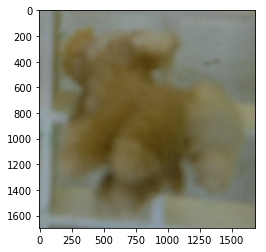

HERE


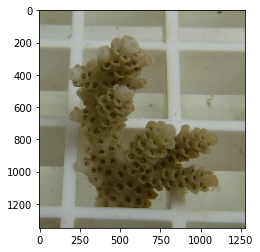

HERE


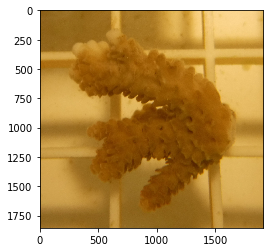

HERE


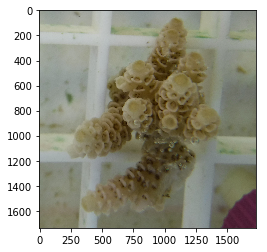

HERE


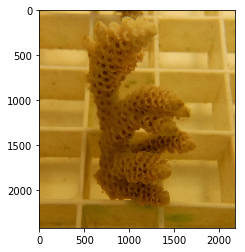

HERE


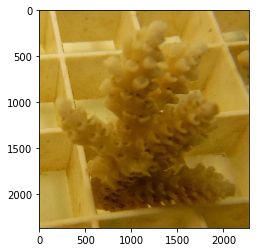

HERE


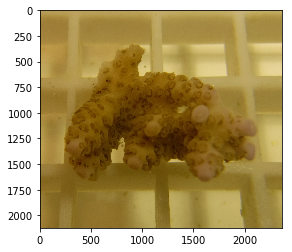

HERE


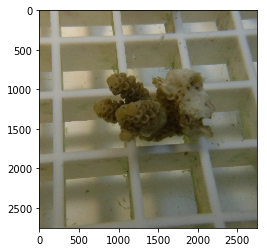

HERE


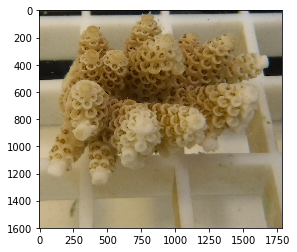

HERE


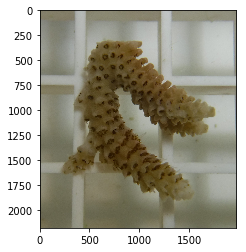

HERE


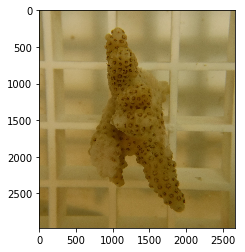

HERE


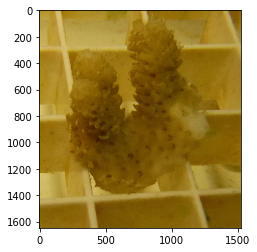

HERE


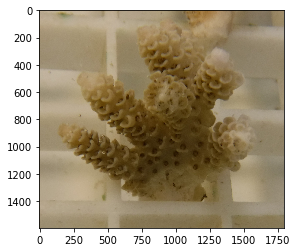

HERE


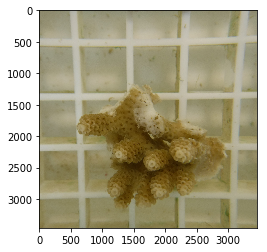

HERE


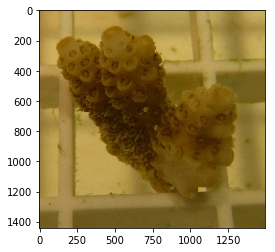

HERE


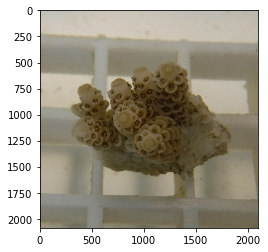

HERE


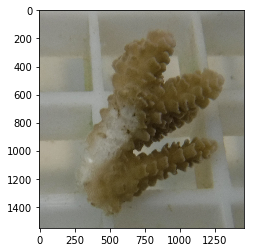

HERE


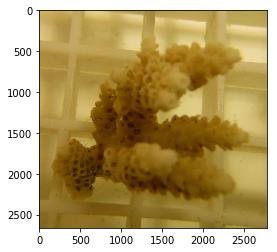

HERE


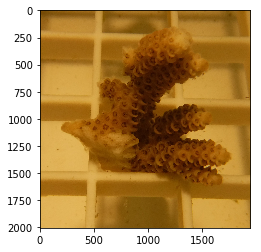

HERE


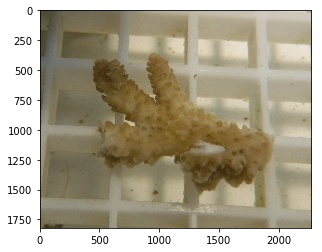

HERE


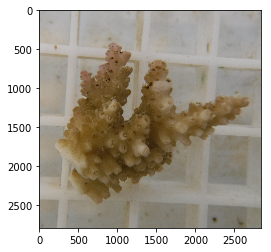

HERE


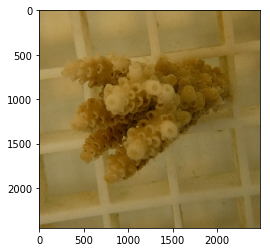

HERE


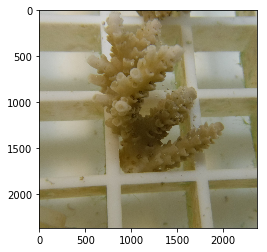

HERE


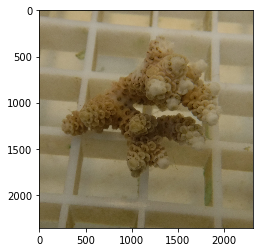

HERE


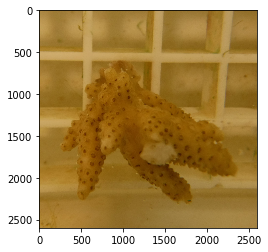

HERE


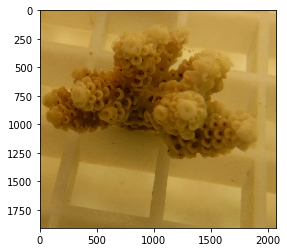

HERE


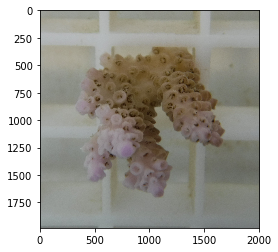

HERE


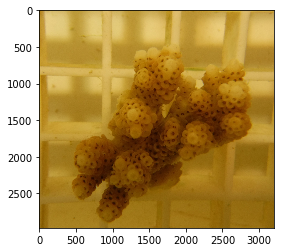

HERE


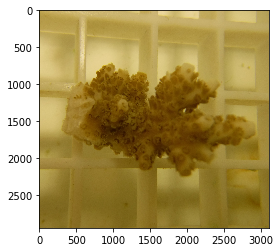

HERE


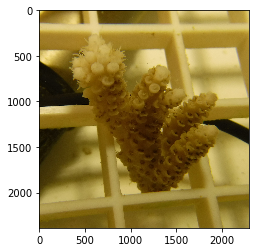

HERE


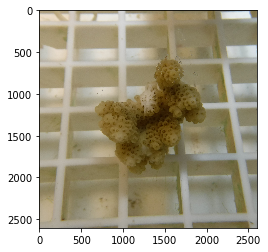

In [61]:
imgNames = os.listdir('../dataset/test/N')
for img in imgNames: 
    print("HERE")
    imgname = '../dataset/test/N/' + img; 
    myimg = load_img(imgname)  # this is a PIL image
    plt.imshow(myimg)
    plt.show()

In [38]:
x_train = np.concatenate(x_train)
x_train.shape

x_test = np.concatenate(x_test)
x_test.shape

(94, 300, 300, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


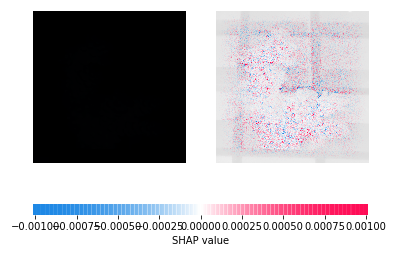

In [39]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 10, replace=True)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:2])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:2])

In [40]:
x_test[1]

array([[[ 0.45964733,  0.45964733, -0.07898695],
        [ 0.43720424,  0.43720424, -0.10143004],
        [ 0.36987495,  0.36987495, -0.16875933],
        ...,
        [ 0.43720424,  0.39231804, -0.12387314],
        [ 0.45964733,  0.41476116, -0.10143004],
        [ 0.5494197 ,  0.43720424, -0.05654386]],

       [[ 0.45964733,  0.45964733, -0.07898695],
        [ 0.43720424,  0.43720424, -0.10143004],
        [ 0.43720424,  0.43720424, -0.10143004],
        ...,
        [ 0.45964733,  0.41476116, -0.10143004],
        [ 0.41476116,  0.36987495, -0.19120243],
        [ 0.52697664,  0.43720424, -0.12387314]],

       [[ 0.39231804,  0.39231804, -0.14631623],
        [ 0.36987495,  0.36987495, -0.16875933],
        [ 0.41476116,  0.41476116, -0.16875933],
        ...,
        [ 0.45964733,  0.41476116, -0.14631623],
        [ 0.5045335 ,  0.45964733, -0.10143004],
        [ 0.48209044,  0.39231804, -0.16875933]],

       ...,

       [[-0.41563338, -0.46051958, -0.9767109 ],
        [-0